<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [345]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_5.sql"

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 1000

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2





## Section 1: Loading event log

In [346]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [347]:
from google.colab import auth
auth.authenticate_user()

In [348]:
# this assumes that the user has access to the mimic-iii dataset 
# replace project name to the project containing mimic-iii
project_name = "processmining-367815" 
from google.cloud import bigquery
client = bigquery.Client(project=project_name)

In [349]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

In [350]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,105764,Transfer,2134-03-01 00:38:40
1,112013,Transfer,2187-02-12 00:42:40
2,150193,Transfer,2192-06-01 01:13:39
3,144980,Transfer,2169-08-14 00:30:19
4,122192,Transfer,2120-04-15 00:32:00
...,...,...,...
230665,178246,Admitted,2134-10-29 07:15:00
230666,148472,Admitted,2106-07-12 18:52:00
230667,156806,Admitted,2123-09-08 06:45:00
230668,100375,Admitted,2129-05-02 00:12:00


## Section 2: Process Discovery

In [351]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-351-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.8/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.8/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

Number of cases: 42652
Number of events: 230668
Start events: {'Admitted': 36389, 'Transfer': 6208, 'Discharged': 55}
End events: {'Discharged': 35125, 'Left ICU': 7510, 'Transfer': 14, 'Admitted': 3}


In [352]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model

event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])

In [353]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

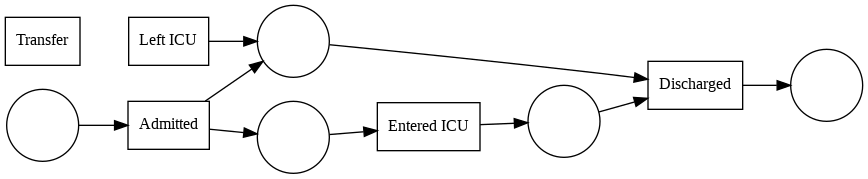

In [354]:
import graphviz
pm.view_petri_net(petri_net=net)

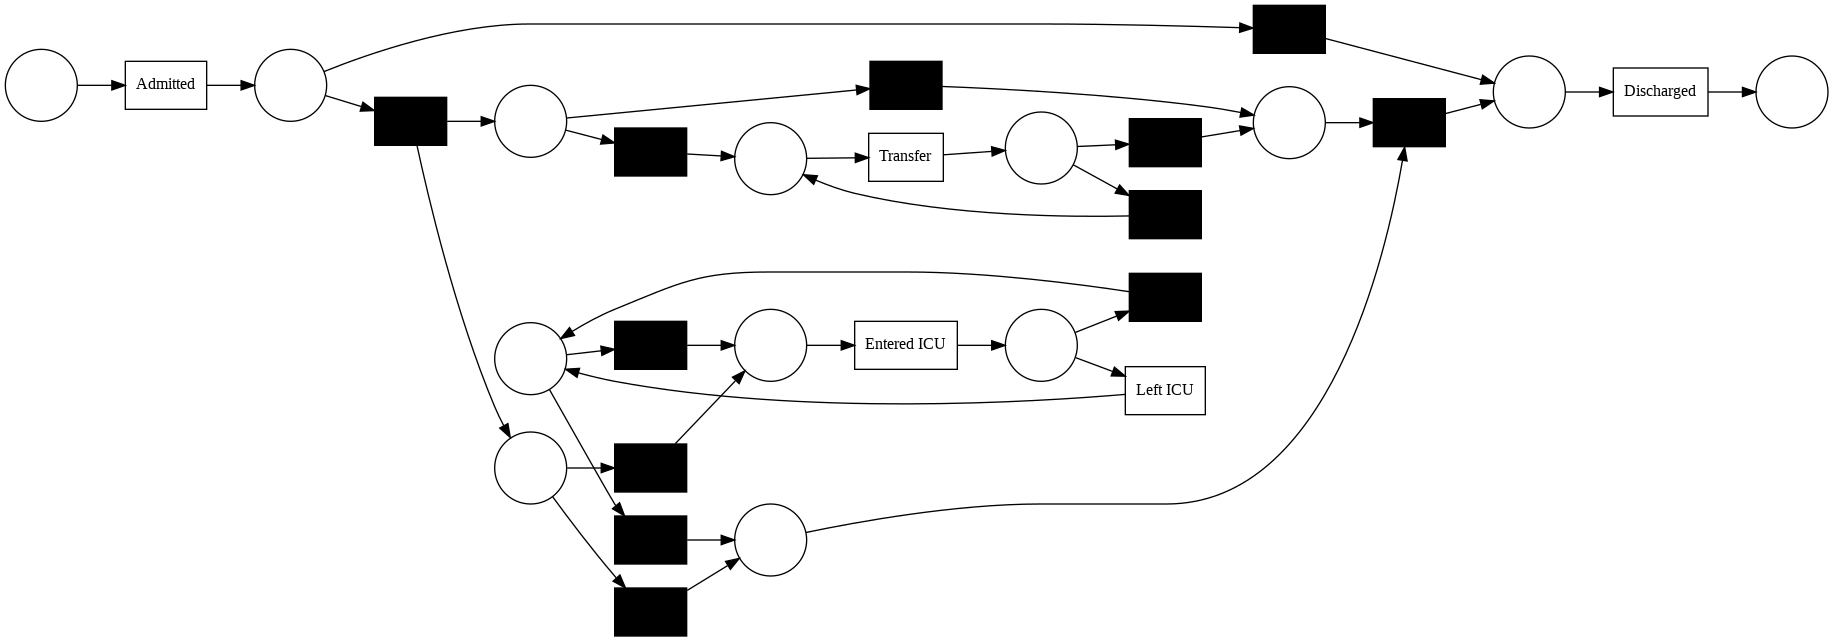

In [355]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

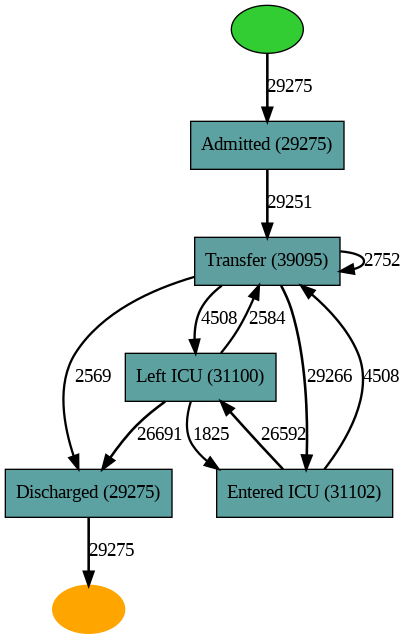

In [356]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

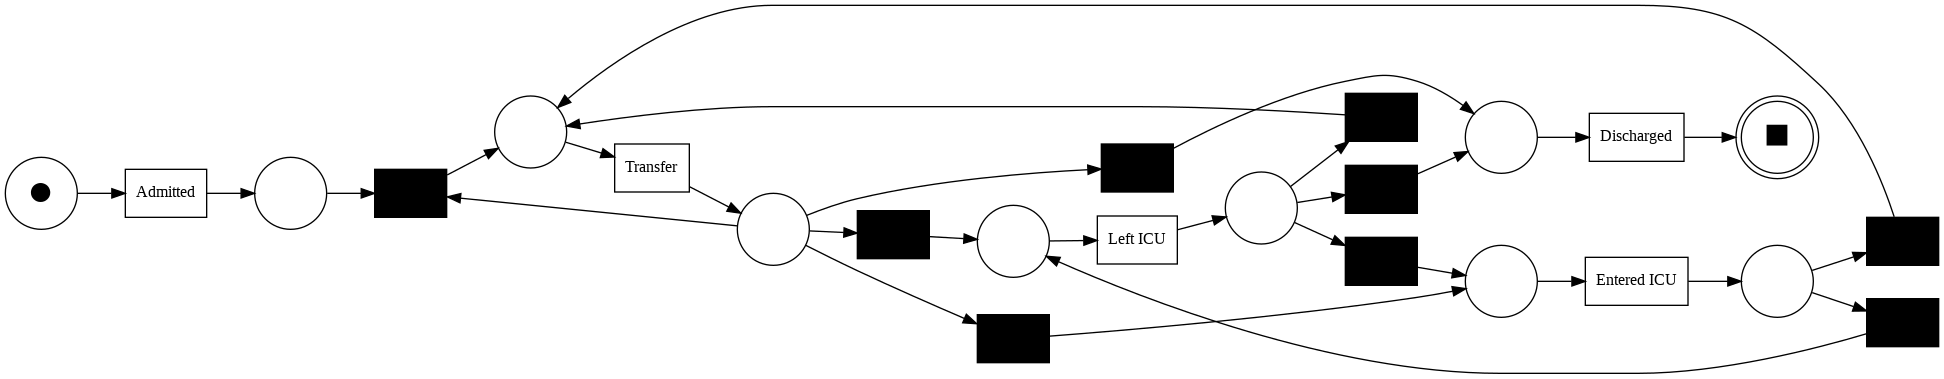

In [357]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

## Section 3: Data Pre Processing



In [358]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = event_log[event_log['trace'].isin(random_traces)]
  return partial_el


In [359]:
partial_el = partial_log(event_log, NUM_TRACES)
# partial_el

In [360]:
# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
n_activities = len(unique_activities) + 1
encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}
encode_activity, decode_activity


({'Admitted': '1',
  'Transfer': '2',
  'Entered ICU': '3',
  'Left ICU': '4',
  'Discharged': '5'},
 {'1': 'Admitted',
  '2': 'Transfer',
  '3': 'Entered ICU',
  '4': 'Left ICU',
  '5': 'Discharged'})

In [361]:
import numpy as np
# create a new labeled data frame

def label(el):
  # initialise data frame 
 
  prefix_arr, suffix_arr, label_arr = [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces} 

  for t in unique_traces:
    traces[t] = el[:][el.trace == t]  
  
  for t in unique_traces:
    df = traces[t].sort_values(by='timestamp')
    activities = []
    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)
    
    length = len(activities)
    
    for i in range(length):

      # prefix = activities[:i]
      label = activities[i]
      prefix = activities[:i]
      suffix = []

      if i != length - 1:
        suffix = activities[i+1:]
      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      label_arr.append(label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'label' : label_arr})
 

In [362]:
from sklearn.model_selection import train_test_split

# label event log
labeled_el = label(partial_el)

# split event log into a train and test set  
train_el, test_el  = train_test_split(labeled_el, test_size=TEST_SIZE, random_state=9)
train_el


,prefix,suffix,label
2989,"[0, 0, 1, 2, 3]","[2, 2, 4, 5, 0]",2
3016,"[0, 0, 1, 2, 3]","[2, 5, 0, 0, 0]",4
2437,"[0, 0, 1, 2, 3]","[5, 0, 0, 0, 0]",4
748,"[0, 1, 2, 3, 4]","[0, 0, 0, 0, 0]",5
2795,"[0, 0, 0, 0, 0]","[2, 3, 4, 5, 0]",1
...,...,...,...
2104,"[0, 0, 0, 1, 2]","[4, 5, 0, 0, 0]",3
501,"[0, 0, 0, 0, 1]","[3, 4, 2, 5, 0]",2
2686,"[0, 1, 2, 2, 3]","[5, 0, 0, 0, 0]",4
348,"[0, 0, 0, 0, 1]","[3, 4, 3, 4, 5]",2


In [363]:
from copy import deepcopy

# declare the label of each activity in the test set as missing
# return actual labels as targets array for validation
def missing(el):
 
  # need to deepcopy targets to derefrence them from dataframe  
  targets = deepcopy(el['label'])
  el['label'] = 'missing'
  return el, targets.to_numpy()

In [364]:
# train_targets = train_el['label'].to_numpy()
test_el, test_targets = missing(test_el)
test_el, test_targets

(               prefix           suffix    label
 2138  [1, 2, 3, 4, 3]  [5, 0, 0, 0, 0]  missing
 2372  [0, 0, 0, 0, 1]  [3, 4, 5, 0, 0]  missing
 644   [0, 0, 0, 1, 2]  [4, 5, 0, 0, 0]  missing
 1269  [0, 0, 0, 1, 2]  [4, 5, 0, 0, 0]  missing
 286   [0, 0, 0, 0, 0]  [2, 3, 4, 5, 0]  missing
 ...               ...              ...      ...
 1697  [0, 1, 2, 3, 4]  [0, 0, 0, 0, 0]  missing
 3648  [0, 0, 1, 2, 3]  [5, 0, 0, 0, 0]  missing
 1554  [0, 0, 1, 2, 3]  [5, 0, 0, 0, 0]  missing
 2053  [0, 0, 0, 1, 2]  [4, 5, 0, 0, 0]  missing
 2559  [0, 0, 0, 0, 0]  [2, 3, 4, 5, 0]  missing
 
 [734 rows x 3 columns],
 array(['4', '2', '3', '3', '1', '5', '1', '1', '5', '2', '4', '2', '3',
        '5', '5', '2', '1', '4', '4', '2', '2', '5', '3', '3', '3', '2',
        '4', '4', '2', '3', '5', '5', '1', '1', '5', '2', '4', '1', '2',
        '3', '4', '4', '3', '4', '3', '2', '5', '4', '5', '5', '5', '1',
        '2', '5', '5', '4', '4', '1', '3', '1', '4', '2', '1', '3', '3',
        '2', '2', '4

In [365]:
# create validation set
train_el, validation_el = train_test_split(train_el, test_size=VALIDATION_SIZE, random_state=9)

In [366]:
from keras.utils import to_categorical

def format_input(el, train=False):

  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x]))

  y = np.array(el['label'])
  y = np.stack(y)
  
  if train is False:
    y_encoded = to_categorical(y,n_activities)
    return x, y_encoded
  
  return x, y

In [367]:
train_x, train_y = format_input(train_el) 
validation_x, validation_y = format_input(validation_el)
test_x, test_y = format_input(test_el, train=True)


## Section 4: Predicting Missing Activities using LSTM

In [324]:
# forwards LSTM
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Softmax, Bidirectional, Embedding


model = Sequential()
model.add(Embedding(input_dim=n_activities, output_dim=50))
model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
model.add(Dense(n_activities, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(train_x[0], train_y, validation_data=(validation_x[0], validation_y), epochs=10)
# model.fit(train_x[0], train, epochs=10)



Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, None, 50)          750       
                                                                 
 lstm_30 (LSTM)              (None, 50)                20200     
                                                                 
 dense_30 (Dense)            (None, 15)                765       
                                                                 
Total params: 21,715
Trainable params: 21,715
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1185/1185 [==============================] - 11s 7ms/step - loss: 1.6345 - accuracy: 0.4232 - val_loss: 1.5523 - val_accuracy: 0.4415
Epoch 2/10
1185/1185 [==============================] - 8s 7ms/step - loss: 1.5545 - accuracy: 0.4441 - val_loss: 1.5414 - val_accuracy: 0.4423
Epoch 3/10
1185/1185 [==

In [325]:
predictions_prefix = model.predict(test_x[0])
# predictions

371/371 [==============================] - 2s 4ms/step


In [326]:
def evaluate(predictions, verbose=False):
  correct = 0 
  incorrect = 0
  for i in range(len(test_targets)):
    prediction = np.argmax(predictions[i])
    if int(prediction) == int(test_targets[i]):
      correct += 1
    else:
      if verbose:
        print(f"predicted : {prediction}; expected : {test_targets[i]}")
      incorrect += 1


  accuracy = correct/(correct + incorrect)
  return accuracy

In [327]:
evaluate(predictions_prefix)

0.44951882491980416

In [328]:
# backwards LSTM

model = Sequential()
model.add(Embedding(input_dim=n_activities, output_dim=50))
model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
model.add(Dense(n_activities, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(train_x[1], train_y, validation_data=(validation_x[1], validation_y), epochs=10)
# model.fit(train_x[0], train, epochs=10)



Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, None, 50)          750       
                                                                 
 lstm_31 (LSTM)              (None, 50)                20200     
                                                                 
 dense_31 (Dense)            (None, 15)                765       
                                                                 
Total params: 21,715
Trainable params: 21,715
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1185/1185 [==============================] - 11s 8ms/step - loss: 1.6089 - accuracy: 0.4214 - val_loss: 1.5277 - val_accuracy: 0.4377
Epoch 2/10
1185/1185 [==============================] - 8s 7ms/step - loss: 1.5127 - accuracy: 0.4465 - val_loss: 1.4964 - val_accuracy: 0.4499
Epoch 3/10
1185/1185 [==

In [329]:
predictions_suffix = model.predict(test_x[1])

371/371 [==============================] - 1s 3ms/step


In [330]:
evaluate(predictions_suffix)

0.46395407732567956

In [331]:
# averaging outputs
predictions = []
for p in zip(predictions_prefix, predictions_suffix):
 
  arr = []
  for i in range(0,4):
    arr.append((p[0][i]+p[1][i])/2)
  predictions += [arr]

predictions = np.array(predictions)

evaluate(predictions, verbose=True)


Streaming output truncated to the last 5000 lines.
predicted : 3; expected : 4
predicted : 3; expected : 7
predicted : 3; expected : 5
predicted : 1; expected : 6
predicted : 3; expected : 5
predicted : 3; expected : 6
predicted : 3; expected : 4
predicted : 3; expected : 9
predicted : 3; expected : 4
predicted : 2; expected : 8
predicted : 3; expected : 7
predicted : 3; expected : 6
predicted : 3; expected : 6
predicted : 3; expected : 6
predicted : 3; expected : 4
predicted : 3; expected : 4
predicted : 3; expected : 4
predicted : 3; expected : 4
predicted : 3; expected : 6
predicted : 3; expected : 11
predicted : 3; expected : 4
predicted : 2; expected : 3
predicted : 3; expected : 9
predicted : 1; expected : 9
predicted : 3; expected : 7
predicted : 3; expected : 4
predicted : 2; expected : 9
predicted : 2; expected : 10
predicted : 3; expected : 10
predicted : 3; expected : 5
predicted : 1; expected : 11
predicted : 3; expected : 5
predicted : 3; expected : 4
predicted : 3; expect

0.3944791490798582

In [372]:
# Bidirectional LSTM
from keras.layers import Bidirectional, Input, concatenate, average
from keras import Model

prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

lstm_layer = LSTM(50)

prefix_lstm = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_input)
suffix_lstm = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_input)

merged = average([prefix_lstm, suffix_lstm], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

model = Model(inputs=[prefix_input, suffix_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 prefix_lstm (Bidirectional)    (None, 100)          20800       ['prefix_input[0][0]']           
                                                                                                  
 suffix_lstm (Bidirectional)    (None, 100)          20800       ['suffix_input[0][0]']           
                                                                                            

In [374]:
model.fit((train_x[0], train_x[1]), train_y, epochs=10)

Epoch 1/10
74/74 [==============================] - 8s 14ms/step - loss: 1.2676 - accuracy: 0.5765
Epoch 2/10
74/74 [==============================] - 1s 14ms/step - loss: 0.5447 - accuracy: 0.8534
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 0.3208 - accuracy: 0.9020
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 0.2215 - accuracy: 0.9280
Epoch 5/10
74/74 [==============================] - 1s 13ms/step - loss: 0.1837 - accuracy: 0.9305
Epoch 6/10
74/74 [==============================] - 1s 13ms/step - loss: 0.1646 - accuracy: 0.9344
Epoch 7/10
74/74 [==============================] - 1s 14ms/step - loss: 0.1527 - accuracy: 0.9416
Epoch 8/10
74/74 [==============================] - 1s 14ms/step - loss: 0.1422 - accuracy: 0.9352
Epoch 9/10
74/74 [==============================] - 1s 14ms/step - loss: 0.1335 - accuracy: 0.9425
Epoch 10/10
74/74 [==============================] - 2s 23ms/step - loss: 0.1237 - accuracy: 0.9519


In [377]:
predictions_bi = model.predict([test_x[0], test_x[1]])
evaluate(predictions_bi)

23/23 [==============================] - 2s 4ms/step


0.952316076294278

##Section 5: Evaluation and Conformance Checking